<a href="https://colab.research.google.com/github/richmondvan/melanoma-detection/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training

Import all modules and mount Google Drive

In [7]:
# Must be run every time!

from pathlib import Path # Manage file paths
import pickle # Storing epoch number
from google.colab import drive # For mounting GDrive

from tensorflow.keras import metrics, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger

# Mount Google Drive
drive.mount('/content/gdrive')

!git clone https://github.com/richmondvan/isic-image-database.git

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
fatal: destination path 'isic-image-database' already exists and is not an empty directory.


Prepare datasets

In [2]:
# Setting up file paths
PATH = "/content/isic-image-database/"

TRAINING_PATH = Path(PATH + "training/")
VALIDATION_PATH = Path(PATH + "validation/")
TEST_PATH = Path(PATH + "test/")

# Create image generators
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.90, 1.10),
    zoom_range=[1, 1.10],
    horizontal_flip=True,
    vertical_flip=True) # Generator for our training data

validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

# Some constants
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
TRAIN_LEN = len(list(TRAINING_PATH.glob("*/*.jpg")))
VALID_LEN = len(list(VALIDATION_PATH.glob("*/*.jpg")))
CLASS_NAMES = ['benign', 'malignant']

# Get generated datasets
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=TRAINING_PATH,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           classes=CLASS_NAMES)

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=VALIDATION_PATH,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              classes=CLASS_NAMES)

Found 8424 images belonging to 2 classes.
Found 1054 images belonging to 2 classes.


Show images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if __name__ == '__main__':


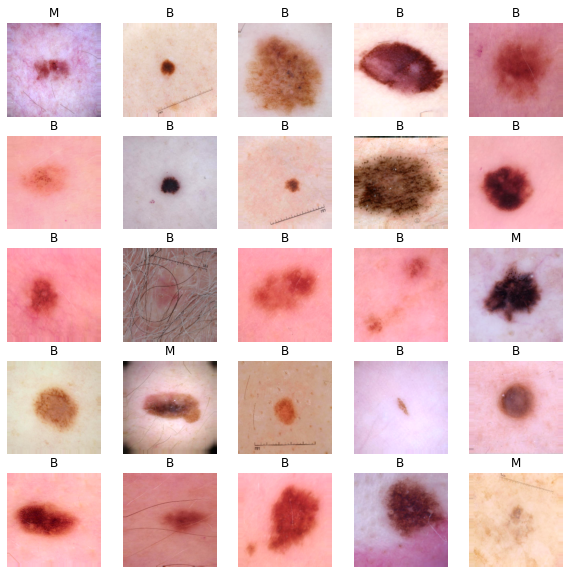

In [3]:
import matplotlib.pyplot as plt
image_batch, label_batch = next(train_data_gen)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

show_batch(image_batch, label_batch)

Prepare metrics and weights

In [4]:
# Get some training weights to offset class imbalance
numBenign = len(list(TRAINING_PATH.glob("benign/*.jpg")))
numMalignant = len(list(TRAINING_PATH.glob("malignant/*.jpg")))
total = numBenign + numMalignant

additionalWeightMultiplier = 1.5

weight_for_0 = (1 / numBenign) * (total) / 2.0 
weight_for_1 = (additionalWeightMultiplier / numMalignant) * (total) / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

# Metrics we will be using to assess accuracy
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
]

{0: 0.5939086294416244, 1: 4.743243243243243}


Prepare model

In [8]:
# Hyperparameters
NEURONS_PER_LAYER = 256
REG_LAMBDA = 0.001
DROPOUT = 0.1
ACTIVATION = "relu"

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

base_model = MobileNetV2(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(DROPOUT),
    Dense(NEURONS_PER_LAYER, kernel_regularizer=regularizers.l2(REG_LAMBDA), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(NEURONS_PER_LAYER, kernel_regularizer=regularizers.l2(REG_LAMBDA), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(NEURONS_PER_LAYER, kernel_regularizer=regularizers.l2(REG_LAMBDA), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(NEURONS_PER_LAYER, kernel_regularizer=regularizers.l2(REG_LAMBDA), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(NEURONS_PER_LAYER, kernel_regularizer=regularizers.l2(REG_LAMBDA), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(NEURONS_PER_LAYER, kernel_regularizer=regularizers.l2(REG_LAMBDA), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(NEURONS_PER_LAYER, kernel_regularizer=regularizers.l2(REG_LAMBDA), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(NEURONS_PER_LAYER, kernel_regularizer=regularizers.l2(REG_LAMBDA), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(1, activation="sigmoid")
])

LEARNING_RATE = 0.001

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=BinaryCrossentropy(from_logits=True),
    metrics=METRICS)

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0

Load model weights and last epoch

In [9]:
# Get last epoch number from pickled file

MODEL_FILEPATH = f"/content/gdrive/My Drive/MelanomaDetectionModels/{NEURONS_PER_LAYER}_8/"
EPOCH_FILEPATH = MODEL_FILEPATH + "epochnum.pkl"

try: 
    infile = open(EPOCH_FILEPATH, 'rb')
    infile.seek(0)
    epoch = pickle.load(infile)
    model.load_weights(MODEL_FILEPATH + f"epoch{epoch}.h5")
    infile.close()
except: 
    # Otherwise start again (only happens if no epoch number found)
    epoch = 0


print(epoch)

0


Prepare CSV logger

In [0]:
# File where we store our CSV history

HISTORY_FILEPATH = MODEL_FILEPATH + "history.csv"

csv_logger = CSVLogger(HISTORY_FILEPATH, append=True)

Train model

In [0]:
# Train for 100 epochs

epochsToTrain = 100

if epoch < epochsToTrain:
    for i in range(epoch, epochsToTrain):
        history = model.fit(x=train_data_gen, 
                            epochs=i+1, 
                            initial_epoch=i, 
                            verbose=1, 
                            validation_data=val_data_gen, 
                            validation_steps=VALID_LEN // batch_size, 
                            steps_per_epoch=TRAIN_LEN // batch_size, 
                            class_weight=class_weight,
                            callbacks = [csv_logger])
        model.save_weights(MODEL_FILEPATH + f"epoch{i + 1}.h5")
        outfile = open(EPOCH_FILEPATH, 'wb')
        pickle.dump(i+1, outfile)
        outfile.close()

263/263 [==============================] - 9730s 37s/step - loss: 1.1597 - accuracy: 0.7012 - tp: 908.0000 - fp: 2091.0000 - tn: 4976.0000 - fn: 416.0000 - precision: 0.3028 - recall: 0.6858 - auc: 0.7443 - val_loss: 1.0437 - val_accuracy: 0.5869 - val_tp: 153.0000 - val_fp: 415.0000 - val_tn: 448.0000 - val_fn: 8.0000 - val_precision: 0.2694 - val_recall: 0.9503 - val_auc: 0.8178
Epoch 2/2
263/263 [==============================] - 431s 2s/step - loss: 0.8399 - accuracy: 0.7481 - tp: 948.0000 - fp: 1734.0000 - tn: 5329.0000 - fn: 380.0000 - precision: 0.3535 - recall: 0.7139 - auc: 0.8054 - val_loss: 0.8257 - val_accuracy: 0.7891 - val_tp: 131.0000 - val_fp: 182.0000 - val_tn: 677.0000 - val_fn: 34.0000 - val_precision: 0.4185 - val_recall: 0.7939 - val_auc: 0.8599
Epoch 3/3
263/263 [==============================] - 431s 2s/step - loss: 0.7876 - accuracy: 0.7519 - tp: 972.0000 - fp: 1724.0000 - tn: 5337.0000 - fn: 358.0000 - precision: 0.3605 - recall: 0.7308 - auc: 0.8146 - val_loss